In [1]:
import diplib as dip
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import string
from tqdm import trange
import seaborn as sns
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from tifffile import tifffile as tiff

matplotlib.rcParams['font.family'] = 'STIXGeneral'
image_dir = 'Images/'

DIPlib -- a quantitative image analysis library
Version 3.4.3 (Mar 21 2024)
For more information see https://diplib.org


In [2]:
img = dip.ImageRead(f'{image_dir}/CHROMO3D.tif')
# img.Show()

# 6.1

In [3]:
image_stack = tiff.imread(f'{image_dir}/CHROMO3D.tif')

depth, y_size, x_size = image_stack.shape
print(f"image stack shape: {image_stack.shape}")

# aspect ratio (y_size / x_size)
aspect_ratio = y_size / x_size
print(f"aspect ratio: {aspect_ratio:.2f}")
print(f"number of slices: {depth}")


image stack shape: (16, 140, 160)
aspect ratio: 0.88
number of slices: 16


(-0.5, 159.5, 139.5, -0.5)

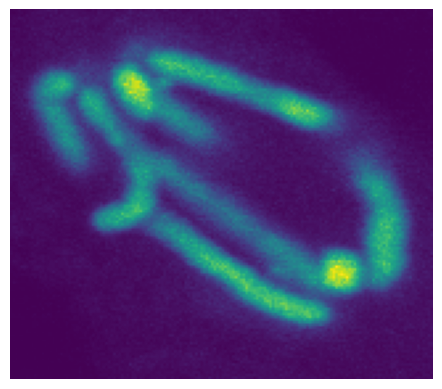

In [4]:
plt.imshow(image_stack[11,:,:])
plt.axis('off')

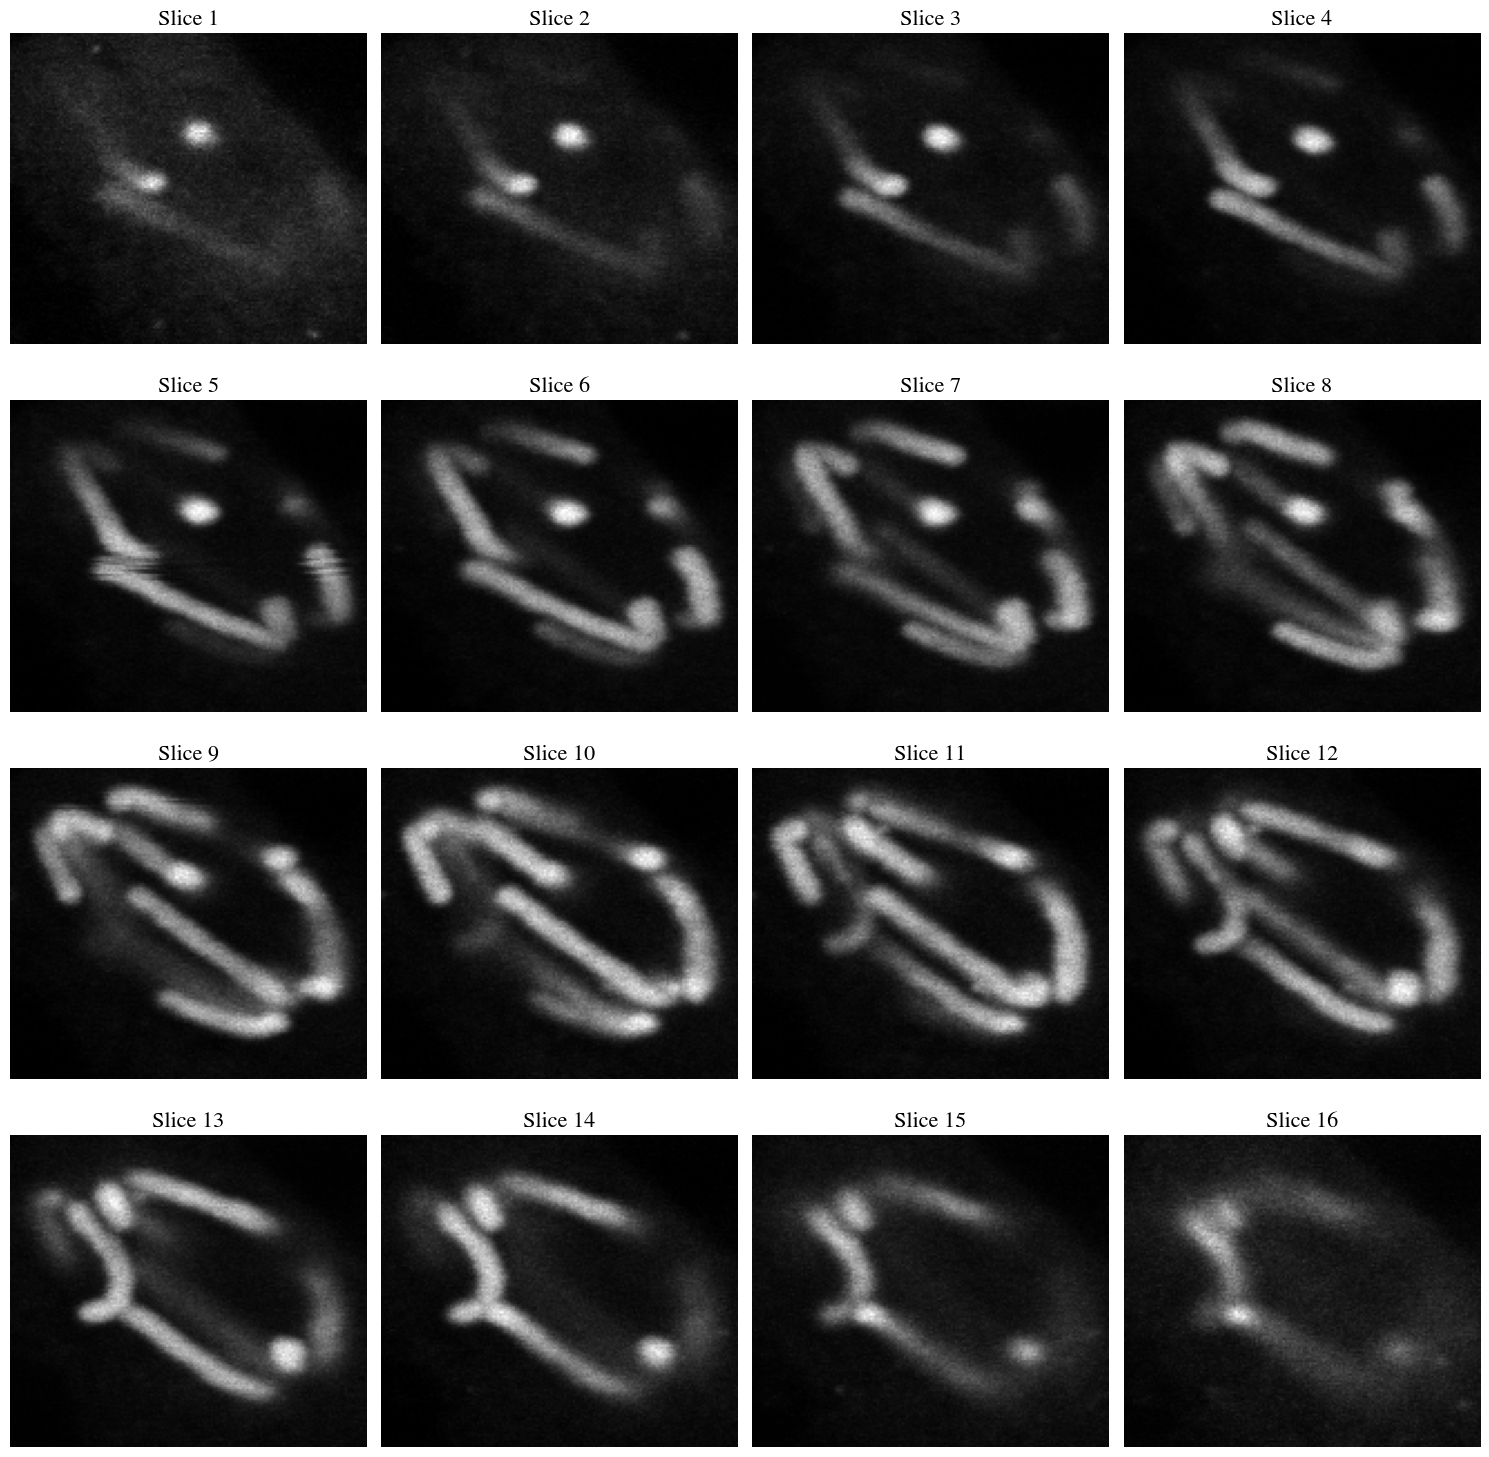

In [5]:
def display_stack(image_stack):
    depth = image_stack.shape[0]
    grid_size = int(np.sqrt(depth))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize =(15,15))
    axes = axes.flatten()

    for i in range(depth):
        axes[i].imshow(image_stack[i, :,:], cmap = "gray")
        axes[i].set_title(f'Slice {i+1}', fontsize=16)
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()
    
display_stack(image_stack)

# 6.2

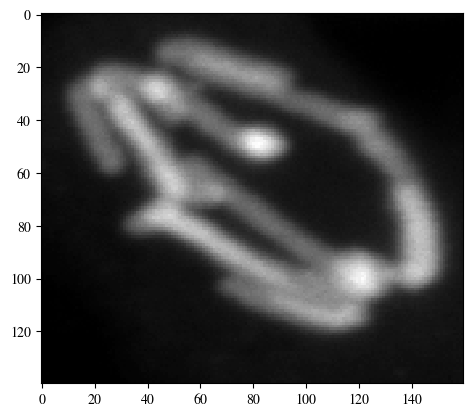

In [6]:
image_2d = np.sum(image_stack, axis=0)
image_2d_dip = dip.Image(image_2d)
image_2d_dip.Show()

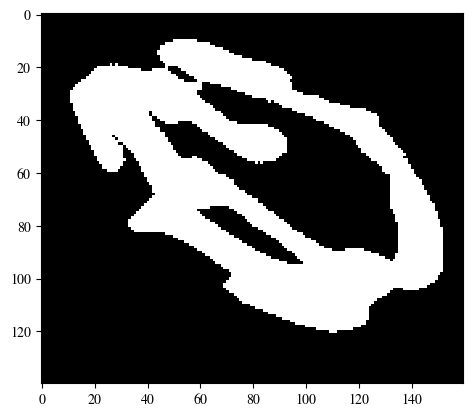

In [7]:
bin_img = dip.OtsuThreshold(image_2d_dip)
bin_img.Show()


In [67]:
def apply_depth_cueing(image_stack):
    depth, y_size, x_size = image_stack.shape
    processed_stack = np.zeros_like(image_stack, dtype=np.float32)

    for i in range(depth):
        plane = image_stack[i, :, :]
        intensity_factor = 0.9 * (depth - i) / depth  # linear scaling
        processed_stack[i, :, :] = plane * intensity_factor

    return processed_stack

In [68]:
thresholded_stack = np.zeros_like(image_stack)
for i in range(depth):
    thresholded_stack[i,:,:] = dip.OtsuThreshold(image_stack[i,:,:])

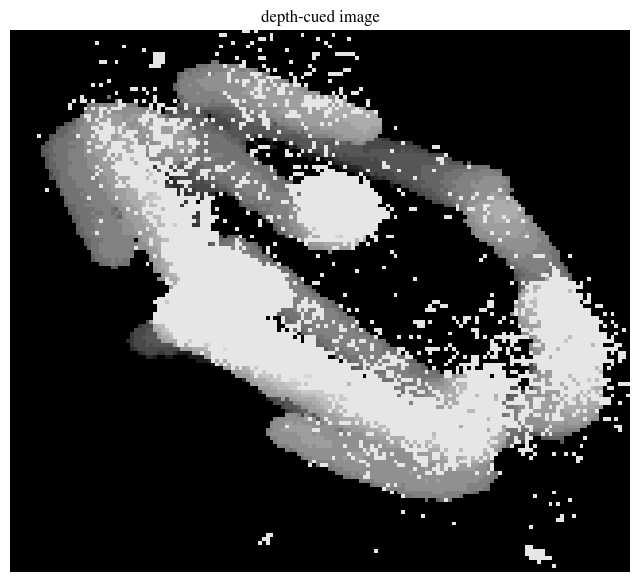

In [75]:
depth_cued_stack = apply_depth_cueing(thresholded_stack)
combined_image = np.max(depth_cued_stack[:-1,:,:], axis=0)
plt.figure(figsize=(8, 8))
plt.title("depth-cued image")
plt.imshow(combined_image, cmap='gray', vmax=1, vmin=0)
plt.axis('off')
plt.show()